**6. Преобразования метрик. CUPED. ЗАДАНИЯ.**

Задания по видео 32 - 37.


# Описание задачи

## Информация из предыдущих этапов

**Постановка кейса.**

В рамках практических заданий мы будем работать аналитиком на платформе по подаче объявлений. По результатам исследований мы выяснили, что недавно введенной функцией доставки пользуются редко. В рамках идей по исправлению ситуации была предложена инициатива выдать скидку в 20% на данную услугу, зачеркнув старую цену и написав рядом новую на карточках объявлений, в которых доступна доставка. Нам поставлена задача оценить данную инициативу.

**Метрики.**

По резульатам командного обсуждения было принято назначить целевой метрикой выручку. Прочие метрики, за которыми ваша команда планирует наблюдать: выручка с доставки, пользователи с доставкой, количество ошибок на экранах доставочный айтемов, количество заказов без доставки.

**Критерий.**

По результатам предыдущего исследования наш выбор пал на тест Стьюдента. Предполагаем, что будем использовать его.

**MDE, N, alpha, beta**

По результатам обсуждения с аналитиками и продуктами было принято решение остановиться на ошибках 1 и 2 рода в 1% при MDE в 1.4% для основной метрики. N = 5 mln в каждой группе, длительность эксперимента - 21 день.

**Разбиение на тест-контроль**

Мы реализовали функцию деления выборки на тест-контроль с помощью остатка от деления от хэша id юзера и соли эксперимента. При этом мы модифицировали функцию так, чтобы данные до начала эксперимента не отличались между собой статистически значимо ни по одной метрике.

**Анализ результатов.**

Ваш коллега проанализировал тест, и оказалось, что ни по 1 метрике не обнаружилось статистически значимой разницы. Хотя тестовая группа и выигрывала по целевой и прокси-метрикам, доверительный интервал перекрывал 0, p value был значительно выше 0.05.

Следующим этапом было решено проанализировать наиболее чувствительный сегмент. Ваши коллеги подготовили такую выборку, на которую тестовое воздействие должно было повлиять наибольшим образом. В нее попали те пользователи, что находятся в удаленых регионах и переходили на карточки объявлений с возможностью доставки. То есть этим юзерам актуальна доставка, и они точно видели тестовое воздействие (или потенциально увидели бы его, если речь идет о контроле). Анализ показал, что результат вроде и положительный, но на грании с тем, что вполне могло получиться и случайно.

## Текущее задание

Вы с коллегами решили, что следует воспользоваться методами понижения дисперсии, чтобы уточнить результаты вашего предыдущего анализа. Вам предстоит реализовать различные методы, изучить их и провалидировать, а в конце - вновь проанализировать результаты с помощью методов понижения дисперсии. Удачи!

# Log, sqrt, outliers: влияние на метрики

В качестве базовых идей по уменьшению дисперсии ваши коллеги предложили следующие идеи:


*   взятие квадратного корня,
*   взятие логарифма (предварительно добавить 1 ко всем наблюдениям, чтобы логарифм был определен),
*   клиппирование: замена всех значений выше 99-го перцентиля на значение 99-го перцентиля.

Для каждого из 3 методов и случая исходной метрики:


*   рассчитайте дисперсию метрики и сделайте выводы по каждому преобразованию,
*   рассчитайте коэффициент вариации и сделайте выводы по каждому преобразованию,
*   рассчитайте MDE (в %) и сделайте выводы по каждому преобразованию. alpha, beta, N, тип гипотезы - как определили раннее на предыдущих эатпах.


В этом задании вам понадобится данные на предпериоде (task_1)


In [179]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import ttest_ind, norm, kstest, uniform
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint
from collections import namedtuple
synthetic_tests_result = namedtuple(
    'synthetic_tests_result',
    ['left_bound', 'significance', 'right_bound'],
)

In [10]:
pre_data = pd.read_csv('task_2.csv')
print(pre_data.info())
pre_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            50000 non-null  int64  
 1   revenue            50000 non-null  float64
 2   delivery_revenue   50000 non-null  float64
 3   has_delivery       50000 non-null  bool   
 4   error_count        50000 non-null  int64  
 5   order_wo_delivery  50000 non-null  int64  
dtypes: bool(1), float64(2), int64(3)
memory usage: 2.0 MB
None


,user_id,revenue,delivery_revenue,has_delivery,error_count,order_wo_delivery
0,5488135039,0.0,0.0,False,0,1
1,7151893663,0.0,0.0,False,0,1
2,6027633760,0.0,0.0,False,0,6
3,5448831829,0.0,0.0,False,0,3
4,4236547993,0.0,0.0,False,0,9
...,...,...,...,...,...,...
49995,5463288039,0.0,0.0,False,0,0
49996,6933104452,0.0,0.0,False,0,0
49997,2336748848,0.0,0.0,False,0,5
49998,8309238794,0.0,0.0,False,0,0


In [56]:
def cap_outl_99_pct(data):
    """Заменяет значения выше 99-го перцентиля на значение 99-го перцентиля"""
    top_1_pct = np.quantile(data, 0.99)
    data_upd = np.where(data > top_1_pct, top_1_pct, data)
    return data_upd

def wo_transform(data):
    """Функция для имитации отсутствия изменений"""
    return data

def calculate_mde_pct(
    data: pd.Series,
    alpha: float = 0.01,
    power: float = 0.99,
    n: int = 10_000_000,
) -> float:
    """
    Функция считает MDE в % для заданной метрики и гиперпараметров:
      - alpha (ош. 1 рода),
      - power (мощность),
      - n (кол-во наблюдений в каждой из двух групп)
    """
    mean = data.mean()
    std = data.std()
    d = tt_ind_solve_power(
        effect_size=None,
        nobs1=n,
        alpha=alpha,
        power=power,
        ratio=1.0,
        alternative='larger',
    )
    mde = round(d * 100, 4)  # MDE в процентах
    return mde

In [52]:
test_func = [
    wo_transform,
    np.sqrt,
    np.log,
    np.log10,
    cap_outl_99_pct
]

metrics = [
    'revenue', 
    'delivery_revenue',
    'has_delivery',
    'error_count',
    'order_wo_delivery'
]

In [59]:
research_result = {func.__name__: [] for func in test_func}
cv_result = {func.__name__: [] for func in test_func}
variance_result = {func.__name__: [] for func in test_func}

for func in test_func:
    for metric in metrics:
        current_data = pre_data[metric]
        
        # Пропускаем столбцы c бинарными значеениями для функций, которые не работают с ними
        if current_data.dtype == bool:
            research_result[func.__name__].append(None)  # Записываем None для булевых столбцов
            cv_result[func.__name__].append(None)
            variance_result[func.__name__].append(None)
            continue
            
        # Добавляем 1 для логарифмирования
        if func in [np.log, np.log10]:
            current_data = current_data + 1  
        transformed_data = func(current_data)
        mde = calculate_mde_pct(transformed_data)
        cv = (transformed_data.std() / transformed_data.mean()) * 100  # Коэффициент вариации в %
        variance = transformed_data.var()  # Дисперсия
        
        research_result[func.__name__].append(mde)
        cv_result[func.__name__].append(cv)
        variance_result[func.__name__].append(variance)

research_result_df = pd.DataFrame(data=research_result, index=metrics)
cv_result_df = pd.DataFrame(data=cv_result, index=metrics)
variance_result_df = pd.DataFrame(data=variance_result, index=metrics)

# Объединение всех результатов в один DataFrame
final_result = pd.concat({
    'MDE': research_result_df,
    'CV': cv_result_df,
    'Variance': variance_result_df
}, axis=0)

final_result.style.background_gradient(cmap='Reds', axis=1)

C:\Program Files\Anaconda\Lib\site-packages\pandas\io\formats\style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Program Files\Anaconda\Lib\site-packages\pandas\io\formats\style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


### Вывод
- Преобразования не повлияли на MDE, но снизили дисперсию и коэффициент вариации. Скорее всего, они сильно снизили среднее.
- Лучше всего сработал десятичный логарифм.
- Для полей с бинарными значениями эти преобразования не подходят

# Log, sqrt, outliers: валидация

В этом задании мы продолжаем работать с данными из task_1. Для каждого из 4 методов (отсутствие преобразования, логарифмирование, взятие корня, клиппирование) провалидируйте корректность применения с помощью 10 тысяч синтетических АА-тестов для всех метрик и сделайте выводы. Ответьте на вопрос: какой общий минус имеют все те 3 преобразования, что вы проанализировали?



In [134]:
def do_synthetic_aa(
    data,
    transform_func=None,
    test_size=0.5,
    test_func=ttest_ind,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АА-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - провести стат. тест (test_func - ttest по умолчанию) и записать p value,
    - повторить шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 1 рода и дов. интервал (относительно уровня alpha),
    - вывести результат и вернуть массив p value (если включен флаг return_pvalues)"""
    p_values = []
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=test_size)
        if transform_func:
            if 'log' in transform_func.__name__:
                control, test = control + 1, test + 1
                control, test = transform_func(control), transform_func(test)
        p_values.append(test_func(control, test).pvalue)
    p_values = np.array(p_values)
    fte = (p_values <= alpha).sum()
    left_real_level, right_real_level = proportion_confint(count=fte, nobs=n_iter, alpha=alpha, method='wilson')
    significance = fte / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level)

def do_synthetic_ab(
    data,
    transform_func=None,
    potential_effect=0.1,
    test_size=0.5,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АB-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - построить ДИ для разницы средних и записать размер эффекта и записать их,
    - повторить предыдущие шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 2 рода и дов. интервал (относительно уровня alpha),
    - вывести результат и вернуть массивы границ ДИ (если включен флаг return_bounds)"""
    left_bounds = []
    right_bounds = []
    absolut_effect = data.mean() * potential_effect
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=0.5)
        test *= 1 + potential_effect
        if transform_func and 'log' in transform_func.__name__:
            control += 1
            test += 1
        control, test = transform_func(control), transform_func(test)
        mean_control = np.mean(control)
        mean_test = np.mean(test)
        var_mean_control  = np.var(control) / len(control)
        var_mean_test  = np.var(test) / len(test)
        difference_mean = mean_test - mean_control
        difference_mean_var = var_mean_control + var_mean_test
        difference_distribution = norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))
        left_bound, right_bound = difference_distribution.ppf([alpha / 2, 1 - alpha / 2])
        left_bounds.append(left_bound)
        right_bounds.append(right_bound)
    left_bounds, right_bounds = np.array(left_bounds), np.array(right_bounds)
    if transform_func and 'del' not in transform_func.__name__:
        if 'log' not in transform_func.__name__:
            absolut_effect = transform_func(data * (1 + potential_effect)).mean() - transform_func(data).mean()
    else:
        absolut_effect = transform_func(data * (1 + potential_effect) + 1).mean() - transform_func(data + 1).mean()
    ste = ((left_bounds > absolut_effect) | (right_bounds < absolut_effect)).sum()
    left_real_level, right_real_level = proportion_confint(count=ste, nobs=n_iter, alpha=alpha, method='wilson')
    significance = ste / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level)

In [135]:
research_result = {
    metric: {
        func.__name__: (
            list(do_synthetic_aa(data=pre_data[metric], transform_func=func, alpha=0.01)) +
            list(do_synthetic_ab(data=pre_data[metric], transform_func=func, alpha=0.01))
            if pre_data[metric].dtype != bool  # Пропускаем булевы столбцы
            else None
        )
        for func in test_func
    }
    for metric in metrics
}

100%|██████████| 10000/10000 [01:07<00:00, 148.15it/s]


In [136]:
# Создаём список для хранения строк таблицы
rows = []

for metric in metrics:
    for func in test_func:
        results = research_result[metric][func.__name__]
        
        if results is not None:
            row = {
                'metric': metric,
                'function': func.__name__,
                'aa_error': results[0],
                'ab_error': results[1],
            }
            rows.append(row)
        else:
            # Если результаты None (для булевых столбцов), добавляем строку с None
            row = {
                'metric': metric,
                'function': func.__name__,
                'aa_error': None,
                'ab_error': None,
            }
            rows.append(row)

research_df = pd.DataFrame(rows).style.format(
    formatter='{:.3%}',
    subset=['aa_error', 'ab_error']
).highlight_null(
    color="blue",
).background_gradient(
    axis='columns',
    subset=['aa_error', 'ab_error'],
    cmap='Reds',
    vmin=0.001,
    vmax=0.2
).set_caption(
    "Валидация преобразований с помощью синтетических АА и АБ тестов"
)
research_df

,metric,function,aa_error,ab_error
0,revenue,wo_transform,0.722%,0.940%
1,revenue,sqrt,0.748%,0.970%
2,revenue,log,0.635%,0.840%
3,revenue,log10,0.774%,1.000%
4,revenue,cap_outl_99_pct,0.800%,1.030%
5,delivery_revenue,wo_transform,0.827%,1.060%
6,delivery_revenue,sqrt,0.959%,1.210%
7,delivery_revenue,log,0.906%,1.150%
8,delivery_revenue,log10,0.809%,1.040%
9,delivery_revenue,cap_outl_99_pct,0.592%,0.790%


### Вывод
- Все преобразования снизили ошибку в АА-тестах
- В АБ-тестах для некоторых метрик значения ошибок выросли
- Все преобразования, которые мы сделали, убирают выбросы (либо преуменьшают значение), которые могут иметь большое значение для бизнеса (например, сегмент пользователей, который приносит больше всего выручки)

# CUPED абсолютный: имплементация и валидация

*   Реализуйте функцию CUPED-преобразования, которая принимает на вход данные по контролю теста за два периода и выдает CUPED-тест и CUPED-контроль.
*   Реализуйте CUPED ttest для абсолютной разницы средних.
*   Провалидируйте t-test на CUPED-данных с помощью 10 тысяч синтетических АА-тестов для всех метрик. Используйте данные из task_1 в качестве псевдоэкспериментального периода и данные из task_6 в качестве псевдопредэкспериментального периода.
  *  Воспользуйтесь 3-мя методами: график распределения p value, доверительный интервал для реального уровня значимости при alpha = 0.05 и критерий Колмагорова-Смирнова для распределения p value.
  *  Прокомментируйте получившийся результат.
*   Провалидируйте его же с помощью синтетических АБ-тестов для метрики revenue в случае эффекта равным +1, +10 и +100 рублей для каждого юзера. Прокомментируйте получившийся результат.

In [167]:
def transform_cuped(control, test, control_before, test_before):
    num = np.cov(control, control_before)[0, 1] + np.cov(test, test_before)[0, 1]
    den = np.var(control_before) + np.var(test_before)
    theta = num / den
    control_cup = control - theta * control_before
    test_cup = test - theta * test_before
    return control_cup, test_cup

def cuped_ttest(
    control,
    test,
    control_before=None,
    test_before=None,
    ci_level=0.05
):
    if control_before is not None:
        control, test = transform_cuped(
            control=control,
            test=test,
            control_before=control_before,
            test_before=test_before,
            )
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    difference_mean = mean_test - mean_control
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))
    left_bound, right_bound = difference_distribution.ppf([ci_level / 2, 1 - ci_level / 2])
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return experiment_result(pvalue, effect, left_bound, right_bound)

def analyze_p_values(p_values, alpha=0.05):
    """Функция для анализа p-value"""
    plt.figure(figsize=(10, 6))
    plt.hist(p_values, bins=50, density=True, alpha=0.6, color='g', label='p-value distribution')
    plt.axhline(1, color='r', linestyle='--', label='Uniform distribution')
    plt.title('Распределение p-value')
    plt.xlabel('p-value')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

    # Доверительный интервал для реального уровня значимости
    fte = (p_values <= alpha).sum()
    left_real_level, right_real_level = proportion_confint(
        count=fte,
        nobs=len(p_values),
        alpha=alpha,
        method='wilson',
    )
    print(f"Доверительный интервал для реального уровня значимости: [{left_real_level:.4f}, {right_real_level:.4f}]")

    # Критерий Колмогорова-Смирнова
    ks_stat, ks_pvalue = kstest(p_values, uniform(0, 1).cdf)
    print(f"Критерий Колмогорова-Смирнова: статистика = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")
    print("\n")

def absolute_ttest(
    control,
    test,
    control_before=None,
    test_before=None,
    ci_level=0.05
):
    if control_before is not None:
        control, test = transform_cuped(
            control=control,
            test=test,
            control_before=control_before,
            test_before=test_before,
        )
    mean_control = np.mean(control)
    mean_test = np.mean(test)
    difference_mean = mean_test - mean_control
    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))
    left_bound, right_bound = difference_distribution.ppf([ci_level / 2, 1 - ci_level / 2])
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return experiment_result(pvalue, effect, left_bound, right_bound)

def do_synthetic_aa(
    data,
    data_before=None,
    test_size=0.5,
    test_func=absolute_ttest,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АА-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - провести стат. тест (test_func - absolute_ttest по умолчанию) и записать p value,
    - повторить шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 1 рода и дов. интервал (относительно уровня alpha),
    - вывести результат и вернуть массив p value (если включен флаг return_pvalues)"""
    p_values = []
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=test_size)
        if data_before is not None:
            control_before = data_before.loc[control.index]
            test_before = data_before.loc[test.index]
        p_values.append(test_func(control, test, control_before, test_before).pvalue)
    p_values = np.array(p_values)
    fte = (p_values <= alpha).sum()
    left_real_level, right_real_level = proportion_confint(
        count=fte,
        nobs=n_iter,
        alpha=alpha,
        method='wilson',
    )
    significance = fte / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level, p_values)

def do_synthetic_ab(
    data,
    data_before=None,
    potential_effect=0.1,
    test_size=0.5,
    test_func=absolute_ttest,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АB-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - построить ДИ для разницы средних и записать размер эффекта и записать их,
    - повторить предыдущие шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 2 рода и дов. интервал (относительно уровня alpha),
    - вернуть значения из предыдущего пункта"""
    left_bounds = []
    right_bounds = []
    absolut_effect = data.mean() * potential_effect
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=0.5)
        test *= 1 + potential_effect
        control_before, test_before = None, None
        if data_before is not None:
            control_before = data_before.loc[control.index]
            test_before = data_before.loc[test.index]
        _, _, left_bound, right_bound = test_func(control, test, control_before, test_before)
        left_bounds.append(left_bound)
        right_bounds.append(right_bound)
    left_bounds, right_bounds = np.array(left_bounds), np.array(right_bounds)
    ste = ((left_bounds > absolut_effect) | (right_bounds < absolut_effect)).sum()
    left_real_level, right_real_level = proportion_confint(
        count=ste,
        nobs=n_iter,
        alpha=alpha,
        method='wilson',
    )
    significance = ste / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level)

In [169]:
pre_data = pd.read_csv('task_2.csv')
pre_pre_data = pd.read_csv('task_6.csv')

df = pre_data.merge(
    right=pre_pre_data,
    how='inner',
    on='user_id',
    suffixes=('_t1', '_t2'),
    validate='one_to_one',
).drop(labels='user_id', axis='columns')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   revenue_t1            50000 non-null  float64
 1   delivery_revenue_t1   50000 non-null  float64
 2   has_delivery_t1       50000 non-null  bool   
 3   error_count_t1        50000 non-null  int64  
 4   order_wo_delivery_t1  50000 non-null  int64  
 5   revenue_t2            50000 non-null  float64
 6   delivery_revenue_t2   50000 non-null  float64
 7   has_delivery_t2       50000 non-null  bool   
 8   error_count_t2        50000 non-null  int64  
 9   order_wo_delivery_t2  50000 non-null  int64  
dtypes: bool(2), float64(4), int64(4)
memory usage: 3.1 MB
None


### Валидация на АА-тестах
Отдельно, так как мы не будем анализировать p-values для АБ-теста

100%|██████████| 10000/10000 [01:55<00:00, 86.23it/s]


Метрика: revenue


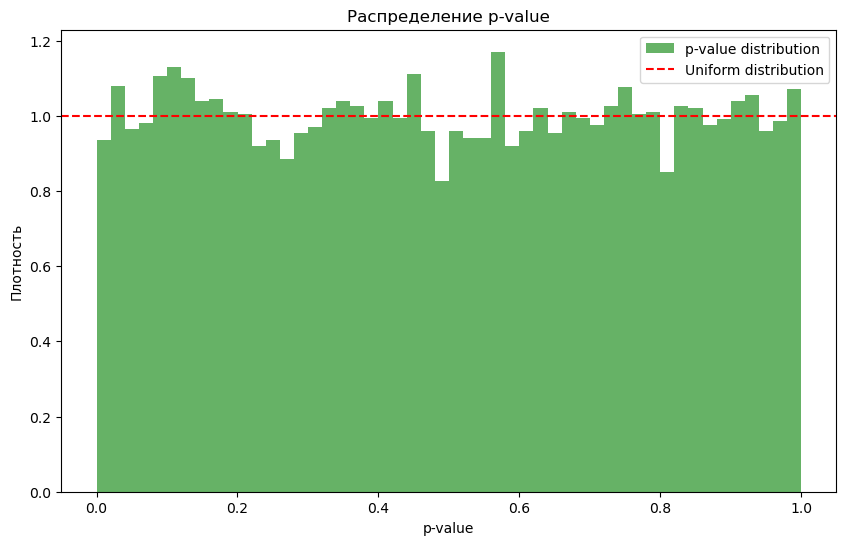

Доверительный интервал для реального уровня значимости: [0.0460, 0.0546]
Критерий Колмогорова-Смирнова: статистика = 0.0096, p-value = 0.3180




100%|██████████| 10000/10000 [01:56<00:00, 86.06it/s]


Метрика: delivery_revenue


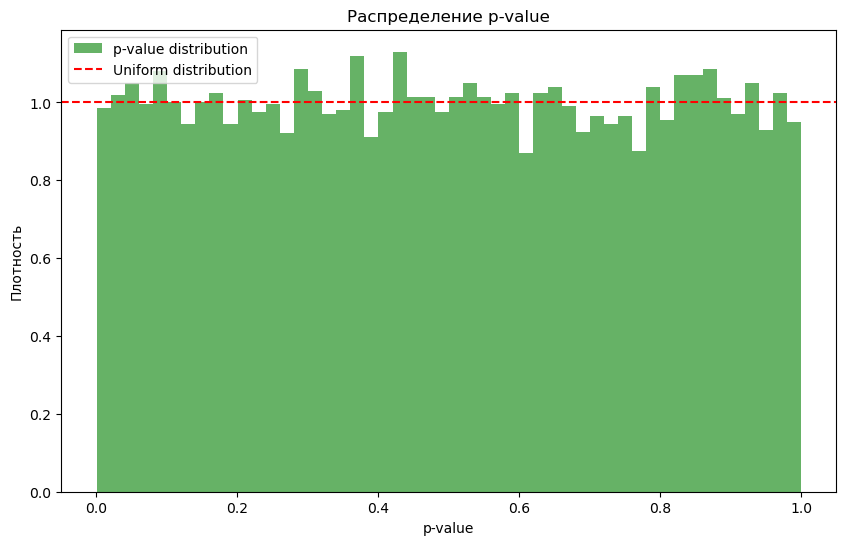

Доверительный интервал для реального уровня значимости: [0.0465, 0.0551]
Критерий Колмогорова-Смирнова: статистика = 0.0058, p-value = 0.8905




100%|██████████| 10000/10000 [02:02<00:00, 81.78it/s]


Метрика: has_delivery


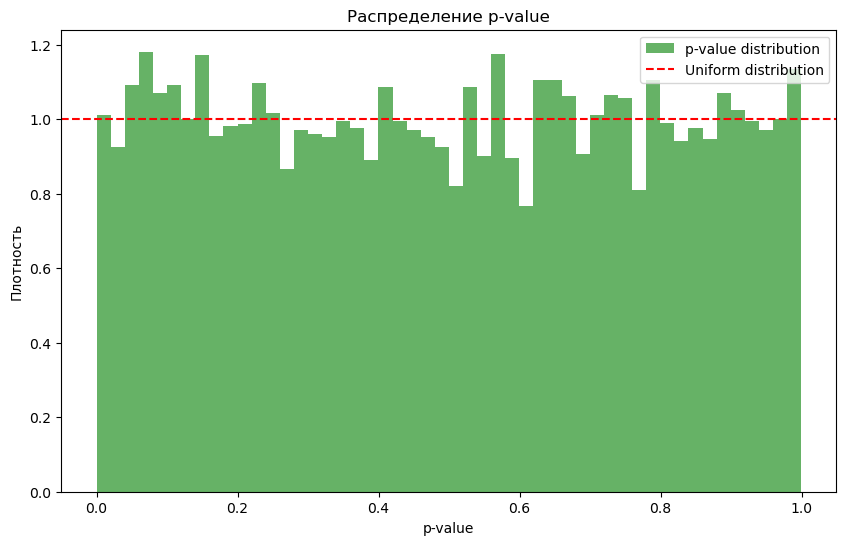

Доверительный интервал для реального уровня значимости: [0.0454, 0.0539]
Критерий Колмогорова-Смирнова: статистика = 0.0121, p-value = 0.1060




100%|██████████| 10000/10000 [02:03<00:00, 80.87it/s]


Метрика: error_count


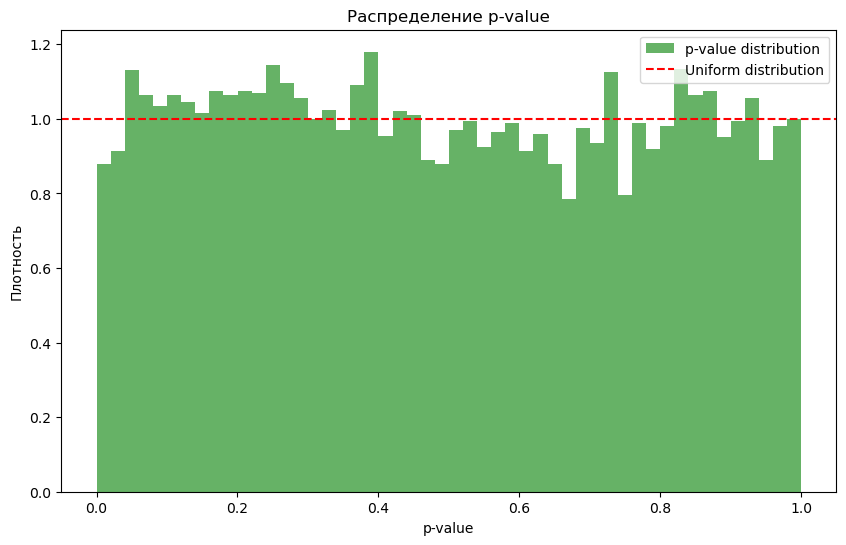

Доверительный интервал для реального уровня значимости: [0.0429, 0.0512]
Критерий Колмогорова-Смирнова: статистика = 0.0204, p-value = 0.0005




100%|██████████| 10000/10000 [02:06<00:00, 79.03it/s]


Метрика: order_wo_delivery


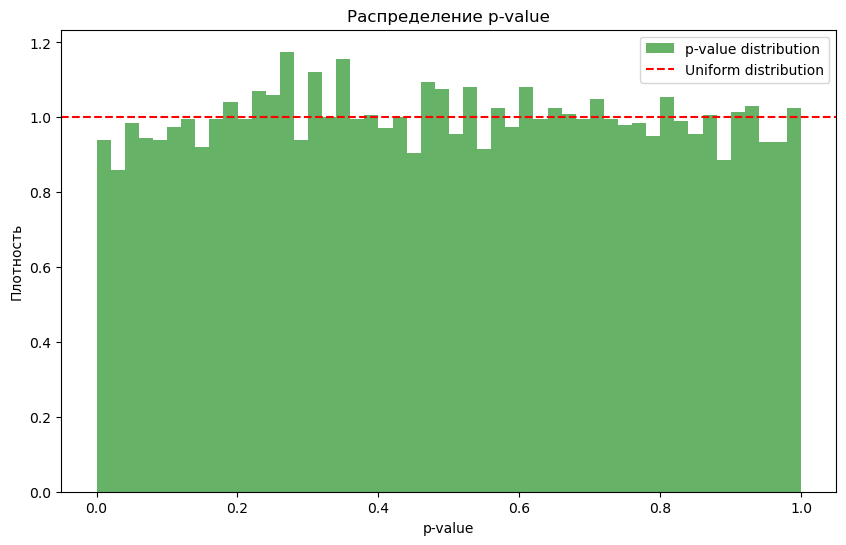

Доверительный интервал для реального уровня значимости: [0.0421, 0.0503]
Критерий Колмогорова-Смирнова: статистика = 0.0111, p-value = 0.1705




,left,significance,right
metric,,,
revenue,0.045994,5.01%,0.054551
delivery_revenue,0.046474,5.06%,0.055071
has_delivery,0.045419,4.95%,0.053927
error_count,0.042927,4.69%,0.051221
order_wo_delivery,0.042066,4.60%,0.050283


In [170]:
results = []
n_iter = 10_000

# Переопределим namedtuple, чтобы он вмещал p_values
synthetic_tests_result = namedtuple(
    'synthetic_tests_result',
    ['left_bound', 'significance', 'right_bound', 'p_values'],
)

# Метрики для анализа
metrics = ['revenue', 'delivery_revenue', 'has_delivery', 'error_count', 'order_wo_delivery']

for metric in metrics:
    data = df[f"{metric}_t2"]
    data_before = df[f"{metric}_t1"]
    
    left, significance, right, p_values = do_synthetic_aa(
        data=data,
        data_before=data_before,
        test_func=absolute_ttest,
        n_iter=n_iter,
    )

    print(f"Метрика: {metric}")
    analyze_p_values(p_values)

    results.append({
        'metric': metric,
        'left': left,
        'significance': significance,
        'right': right,
    })

research_result_upd_pd = pd.DataFrame(results)
research_result_upd_pd.set_index(['metric'], inplace=True)

styled_df = (
    research_result_upd_pd.style
    .format(
        formatter='{:.2%}',
        subset=['significance']
    )
    .highlight_null(
        color="blue",
    )
    .background_gradient(
        axis='columns',
        subset=['significance'],
        cmap='Reds',
        vmin=0.05,
        vmax=0.2
    )
    .set_caption(
        "Валидация CUPED с помощью синтетических АА тестов"
    )
)

styled_df

### Валидация на АБ-тестах

In [171]:
results = []
abs_effects = [1, 10, 100]
n_iter = 10_000

# Переопределим namedtuple для результатов
synthetic_tests_result = namedtuple(
    'synthetic_tests_result',
    ['left_bound', 'significance', 'right_bound'],
)

for metric in metrics:
    for effect in abs_effects:
        data = df[f"{metric}_t2"]
        data_before = df[f"{metric}_t1"]

        left, significance, right = do_synthetic_ab(
            data=data,
            data_before=data_before,
            test_func=absolute_ttest,
            potential_effect=effect,
            n_iter=n_iter,
        )

        results.append({
            'effect': effect,
            'metric': metric,
            'left': left,
            'significance': significance,
            'right': right,
        })

research_result_upd_pd = pd.DataFrame(results)
research_result_upd_pd.set_index(['metric', 'effect'], inplace=True)

styled_df = (
    research_result_upd_pd.style
    .format(
        formatter='{:.2%}',
        subset=['significance']
    )
    .highlight_null(
        color="blue",
    )
    .background_gradient(
        axis='columns',
        subset=['significance'],
        cmap='Reds',
        vmin=0.05,
        vmax=0.2
    )
    .set_caption(
        "Валидация CUPED с помощью синтетических АБ тестов"
    )
)

styled_df

100%|██████████| 10000/10000 [02:09<00:00, 77.21it/s]


### Выводы:
- Абсолютный CUPED прошёл валидацию АА-тестами, ошибки по всем метрикам не выше 0,05 (0,05 входит в доверительный интервал). По распределению p-value и критерию Колмогорова-Смирнова все распределения p-value близки к равномерному, однако delivery_revenue несколько отличается (Сама KS-статистика показывает близость к равномерному, но p-value менее 0,05, что указывает на отличие)
- Абсолютный CUPED прошёл валидацию АБ-тестами, ошибки по всем метрикам не выше 0,05.

# CUPED относительный: имплементация и валидация

*   Реализуйте CUPED ttest для относительной разницы средних.
*   Провалидируйте t-test на CUPED-данных с помощью 10 тысяч синтетических АА-тестов для всех метрик. Используйте данные из task_1 в качестве псевдоэкспериментального периода и данные из task_6 в качестве псевдопредэкспериментального периода.
  *  Воспользуйтесь 3-мя методами: график распределения p value, доверительный интервал для реального уровня значимости при alpha = 0.05 и критерий Колмагорова-Смирнова для распределения p value.
  *  Прокомментируйте получившийся результат.
*   Провалидируйте его же с помощью синтетических АБ-тестов для метрики revenue в случае эффекта равным +1%, +10% и +100% для каждого юзера. Прокомментируйте получившийся результат.

In [198]:
def relative_cuped(control,
    test,
    control_before,
    test_before,
    ci_level=0.05):
    
    control_cup, test_cup = transform_cuped(control, test, control_before, test_before)
    n_test = test.shape[0]
    n_control = control.shape[0]
    mean_control = control.mean()
    var_mean_control  = control.var(ddof=1) / n_control
    
    # Вычисляем относительную разницу средних
    difference_mean_cup = test_cup.mean() - control_cup.mean()
    var_mean_control_cup  = control_cup.var(ddof=1) / n_control
    var_mean_test_cup  = test_cup.var(ddof=1) / n_test
    cov_c_c_cup = np.cov(control_cup, control)[0, 1]
    rel_var_1_term = (var_mean_control_cup + var_mean_test_cup) / (mean_control ** 2)
    rel_var_2_term = var_mean_control * ((difference_mean_cup ** 2) / (mean_control ** 4))
    rel_var_3_term = 2 * (difference_mean_cup / (mean_control ** 3)) * cov_c_c_cup / n_control
    relative_var =  rel_var_1_term + rel_var_2_term + rel_var_3_term
    relative_mu = difference_mean_cup / mean_control
    
    # Выполняем t-test для относительной разницы
    relative_distribution = norm(loc=relative_mu, scale=np.sqrt(relative_var))
    left_bound, right_bound = relative_distribution.ppf([ci_level / 2, 1 - ci_level / 2])
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    effect = relative_mu
    
    return experiment_result(pvalue, effect, left_bound, right_bound)

def do_synthetic_aa_relative(
    data,
    data_before=None,
    test_size=0.5,
    test_func=absolute_ttest,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АА-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - провести стат. тест (test_func - absolute_ttest по умолчанию) и записать p value,
    - повторить шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 1 рода и дов. интервал (относительно уровня alpha),
    - вывести результат и вернуть массив p value (если включен флаг return_pvalues)"""
    p_values = []
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=test_size)
        if data_before is not None:
            control_before = data_before.loc[control.index]
            test_before = data_before.loc[test.index]
        p_values.append(test_func(control, test, control_before, test_before).pvalue)
    p_values = np.array(p_values)
    fte = (p_values <= alpha).sum()
    left_real_level, right_real_level = proportion_confint(
        count=fte,
        nobs=n_iter,
        alpha=alpha,
        method='wilson',
    )
    significance = fte / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level)

# Переобъявим функцию для валидации в АБ, так как нам нужно сравнивать ошибку с относительным эффектом
def do_synthetic_ab_relative(
    data,
    data_before=None,
    potential_effect=0.1,
    test_size=0.5,
    test_func=absolute_ttest,
    alpha=0.05,
    n_iter=10_000,
):
    """функция принимает np.array или pd.Series,
    после чего проводит синтетические АB-тесты по след. алгоритму:
    - разделить на тест и контроль (доля теста = test_size),
    - построить ДИ для разницы средних и записать размер эффекта и записать их,
    - повторить предыдущие шаги n_iter (10 тысяч раз по умолчанию),
    - рассчитать % ошибок 2 рода и дов. интервал (относительно уровня alpha),
    - вернуть значения из предыдущего пункта"""
    left_bounds = []
    right_bounds = []
    for i in tqdm(range(n_iter)):
        control, test = train_test_split(data, test_size=0.5)
        test *= 1 + potential_effect
        control_before, test_before = None, None
        if data_before is not None:
            control_before = data_before.loc[control.index]
            test_before = data_before.loc[test.index]
        _, _, left_bound, right_bound = test_func(control, test, control_before, test_before)
        left_bounds.append(left_bound)
        right_bounds.append(right_bound)
    left_bounds, right_bounds = np.array(left_bounds), np.array(right_bounds)
    ste = ((left_bounds > potential_effect) | (right_bounds < potential_effect)).sum()
    left_real_level, right_real_level = proportion_confint(
        count=ste,
        nobs=n_iter,
        alpha=alpha,
        method='wilson',
    )
    significance = ste / n_iter
    return synthetic_tests_result(left_real_level, significance, right_real_level)

### Валидация на АА-тестах

In [200]:
results = []
n_iter = 10_000

for metric in metrics:
    data = df[f"{metric}_t2"]
    data_before = df[f"{metric}_t1"]
    
    left, significance, right = do_synthetic_aa_relative(
        data=data,
        data_before=data_before,
        test_func=absolute_ttest,
        n_iter=n_iter,
    )

    results.append({
        'metric': metric,
        'left': left,
        'significance': significance,
        'right': right,
    })

research_result_upd_pd = pd.DataFrame(results)
research_result_upd_pd.set_index(['metric'], inplace=True)

styled_df = (
    research_result_upd_pd.style
    .format(
        formatter='{:.2%}',
        subset=['significance']
    )
    .highlight_null(
        color="blue",
    )
    .background_gradient(
        axis='columns',
        subset=['significance'],
        cmap='Reds',
        vmin=0.05,
        vmax=0.2
    )
    .set_caption(
        "Валидация относительного CUPED с помощью синтетических АА тестов"
    )
)

styled_df

100%|██████████| 10000/10000 [01:35<00:00, 104.72it/s]


,left,significance,right
metric,,,
revenue,0.048106,5.23%,0.056838
delivery_revenue,0.046090,5.02%,0.054655
has_delivery,0.047338,5.15%,0.056007
error_count,0.041300,4.52%,0.049449
order_wo_delivery,0.047914,5.21%,0.056630


### Валидация на АБ-тестах

In [201]:
results = []
abs_effects = [1, 10, 100]
n_iter = 10_000

for metric in metrics:
    for effect in abs_effects:
        data = df[f"{metric}_t2"]
        data_before = df[f"{metric}_t1"]

        left, significance, right = do_synthetic_ab(
            data=data,
            data_before=data_before,
            test_func=absolute_ttest,
            potential_effect=effect,
            n_iter=n_iter,
        )

        results.append({
            'effect': effect,
            'metric': metric,
            'left': left,
            'significance': significance,
            'right': right,
        })

research_result_upd_pd = pd.DataFrame(results)
research_result_upd_pd.set_index(['metric', 'effect'], inplace=True)

styled_df = (
    research_result_upd_pd.style
    .format(
        formatter='{:.2%}',
        subset=['significance']
    )
    .highlight_null(
        color="blue",
    )
    .background_gradient(
        axis='columns',
        subset=['significance'],
        cmap='Reds',
        vmin=0.05,
        vmax=0.2
    )
    .set_caption(
        "Валидация относительного CUPED с помощью синтетических АБ тестов"
    )
)

styled_df

100%|██████████| 10000/10000 [01:58<00:00, 84.33it/s]


### Выводы:
- Относительный CUPED прошёл валидацию АА-тестами, ошибки по всем метрикам не выше 0,05 (0,05 входит в доверительный интервал).
- Абсолютный CUPED прошёл валидацию АБ-тестами, ошибки по всем метрикам не выше 0,05.
- CUPED успешно обнаруживает эффекты в синтетических данных, особенно для больших эффектов (10 и 100).
- Для малых эффектов (1) уровень значимости также низкий, что говорит о том, что CUPED корректно работает и для небольших изменений.

# CUPED: переоценка результатов теста



*   Проведите анализ теста аналогично заданию 5, но теперь с использованием CUPED ttest'а.
*   Прокомментируйте различия в результатах по сравнению с анализом без CUPED-версии.



In [216]:
task_5 = pd.read_csv('task_5.csv')

pre_data = pd.read_csv('task_2.csv')

df = task_5.merge(
    right=pre_data,
    how='inner',
    on='user_id',
    suffixes=('_t1', '_t2'),
    validate='one_to_one',
).drop(labels='user_id', axis='columns')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   revenue_t1            50000 non-null  float64
 1   delivery_revenue_t1   50000 non-null  float64
 2   has_delivery_t1       50000 non-null  bool   
 3   error_count_t1        50000 non-null  int64  
 4   order_wo_delivery_t1  50000 non-null  int64  
 5   is_test               50000 non-null  bool   
 6   revenue_t2            50000 non-null  float64
 7   delivery_revenue_t2   50000 non-null  float64
 8   has_delivery_t2       50000 non-null  bool   
 9   error_count_t2        50000 non-null  int64  
 10  order_wo_delivery_t2  50000 non-null  int64  
dtypes: bool(3), float64(4), int64(4)
memory usage: 3.2 MB
None


In [217]:
test_result = {
    'metric': [],
    'p_value': [],
    '99% low, %': [],
    'effect, %': [],
    '99% high, %': []
}

for metric in metrics:
    test = df[df['is_test']][f"{metric}_t2"]
    control = df[~df['is_test']][f"{metric}_t2"]
    control_before = df.loc[control.index][f"{metric}_t1"]
    test_before = df.loc[test.index][f"{metric}_t1"]

    try:
        pvalue, effect, left_bound, right_bound = relative_cuped(
            control,
            test,
            control_before,
            test_before,
            ci_level=0.01
        )
    except Exception as e:
        print(f"Ошибка при расчете метрики {metric}: {e}")
        continue

    test_result['metric'].append(metric)
    test_result['p_value'].append(pvalue)
    test_result['99% low, %'].append(left_bound * 100)
    test_result['effect, %'].append(effect * 100)
    test_result['99% high, %'].append(right_bound * 100)

test_result_df = pd.DataFrame(test_result)

styled_df = test_result_df.style.format(
    '{:.3f}',
    subset=['p_value', '99% low, %', 'effect, %', '99% high, %']
).background_gradient(
    cmap='Blues', 
    axis='rows',
    subset=['p_value', '99% low, %', 'effect, %', '99% high, %']
)
styled_df

,metric,p_value,"99% low, %","effect, %","99% high, %"
0,revenue,0.000,-8.835,-7.073,-5.310
1,delivery_revenue,0.128,-20.852,-7.741,5.369
2,has_delivery,0.000,-22.305,-16.628,-10.951
3,error_count,0.776,-7.644,-0.761,6.122
4,order_wo_delivery,0.910,-1.675,0.077,1.828


### Выводы
- В отличие от версии без преобразования изменения стали видны.
- Внедрение скидки привело к значительному снижению выручки на ~7%, это уменьшение не случайно. Доверительный интервал: от -8.835% до -5.310%.
- Изменение не оказало статистически значимого влияния на выручку от доставки. Однако отрицательный эффект может указывать на потенциальный риск снижения выручки.
- Внедрение изменения привело к значительному снижению доли пользователей с доставкой на ~16.6%. Это может указывать на ухудшение пользовательского опыта, по какой-то причине пользователи стали реже ставить доставку в объявлении.
- Изменение не оказало значимого влияния на количество ошибок. Это может быть связано с тем, что изменение не затрагивало функциональность, связанную с ошибками.
- Изменение не оказало значимого влияния на количество заказов без доставки. Это может указывать на то, что изменение не повлияло на поведение пользователей в этой категории.